# DeepFashion Dataset
a notebook to explore the DeepFashion dataset in order to prepare a `Dataset` class and `Dataloader` 

Note that the data used for Text2Human project was processed vs the original DeepFashion-MultiModal thus we might want to use this dataset, as the images are already aligned


In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
import pandas as pd
%matplotlib inline

In [2]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

# Explore the images

## DeepFashion-MultiModal

In [ ]:
dfmm_path = '/home/guy/sd1tb/datasets/deep_fashion/DeepFashion-MultiModal/images'
imgs_filenames=os.listdir(dfmm_path)
len(imgs_filenames)


In [ ]:
imsz = [Image.open(os.path.join(dfmm_path,im)).size for im in imgs_filenames]
imgs = [Image.open(os.path.join(dfmm_path,im)) for im in imgs_filenames[100:110]]
# plt.imshow(img)

In [ ]:
np.all([s==imsz[0] for s in imsz])

In [ ]:
[s for s in imsz if s != imsz[0] ]

In [ ]:
df=pd.DataFrame(imsz,columns=['x','y'])
df['new_col'] = list(zip(df.x, df.y))
df.head()

In [ ]:
df.new_col.value_counts()

In [ ]:
# resize the images with a limit on each axis size, while maintaining aspect ratio
size=(256,256)
[i.thumbnail(size) for i in imgs]
[im.size for im in imgs]

In [ ]:
[im.size for im in imgs]

## Text2Human Processed dataset

In [ ]:
t2h_path = '/home/guy/sd1tb/datasets/deep_fashion/Text2Human/train_images'
imgs_filenames=os.listdir(t2h_path)
len(imgs_filenames)


In [ ]:
t2h_imsz = [Image.open(os.path.join(t2h_path,im)).size for im in imgs_filenames]
np.all([s==t2h_imsz[0] for s in t2h_imsz])

In [ ]:
t2h_imsz[0]

In [ ]:
imgs = [Image.open(os.path.join(t2h_path,im)) for im in imgs_filenames[:20]]


In [ ]:
size

In [ ]:
size=(256,256)
imgs_tn=imgs.copy()
[i.thumbnail(size) for i in imgs_tn]
image_grid(imgs_tn,4,5)

## DeepFashion dataset


### Fashion Synthesis Benchmark

In [4]:
import h5py

In [6]:
f = h5py.File('/home/guy/sd1tb/datasets/deep_fashion/G2.h5','r')
for k in f.keys():
    print(k)
    print(type(f[k]))

b_
<class 'h5py._hl.dataset.Dataset'>
ih
<class 'h5py._hl.dataset.Dataset'>
ih_mean
<class 'h5py._hl.dataset.Dataset'>


In [7]:
b=f['b_']
for k in b.keys():
    print(k)

AttributeError: 'Dataset' object has no attribute 'keys'

### Other Benchmarks

In [4]:
from glob import glob as Glob

In [5]:
benchmarks = [os.path.basename(bm) for bm in Glob('/home/guy/sd1tb/datasets/deep_fashion/DeepFashion/*') if os.path.isdir(bm)]
benchmarks

['Category and Attribute Prediction Benchmark',
 'Fashion Synthesis Benchmark',
 'Fashion Landmark Detection Benchmark',
 'In-shop Clothes Retrieval Benchmark',
 'Consumer-to-shop Clothes Retrieval Benchmark']

In [6]:
img_fn=[i for i in Glob(f'/home/guy/sd1tb/datasets/deep_fashion/DeepFashion/{benchmarks[3]}/Img/**/*.jpg',recursive=True)] # if 'front' in i]
len(img_fn)

52712

In [7]:
imsz = [Image.open(im).size for im in img_fn]
df=pd.DataFrame(imsz,columns=['x','y'])
df['new_col'] = list(zip(df.x, df.y))
df['img_fn']=img_fn
df['new_col'].value_counts()

(256, 256)    52712
Name: new_col, dtype: int64

(36, 64)


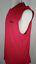

In [30]:
# display the smallest image in the dataset
# img=Image.open(df.loc[df['x']==70,'img_fn'])
img=Image.open(df.loc[df['x']==df['x'].min(),'img_fn'].values[0])
print(img.size)
img

<AxesSubplot:>

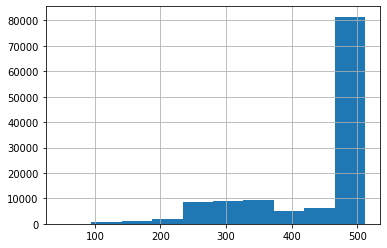

In [36]:
df['y'].hist()

In [ ]:
df['x'].sort_values

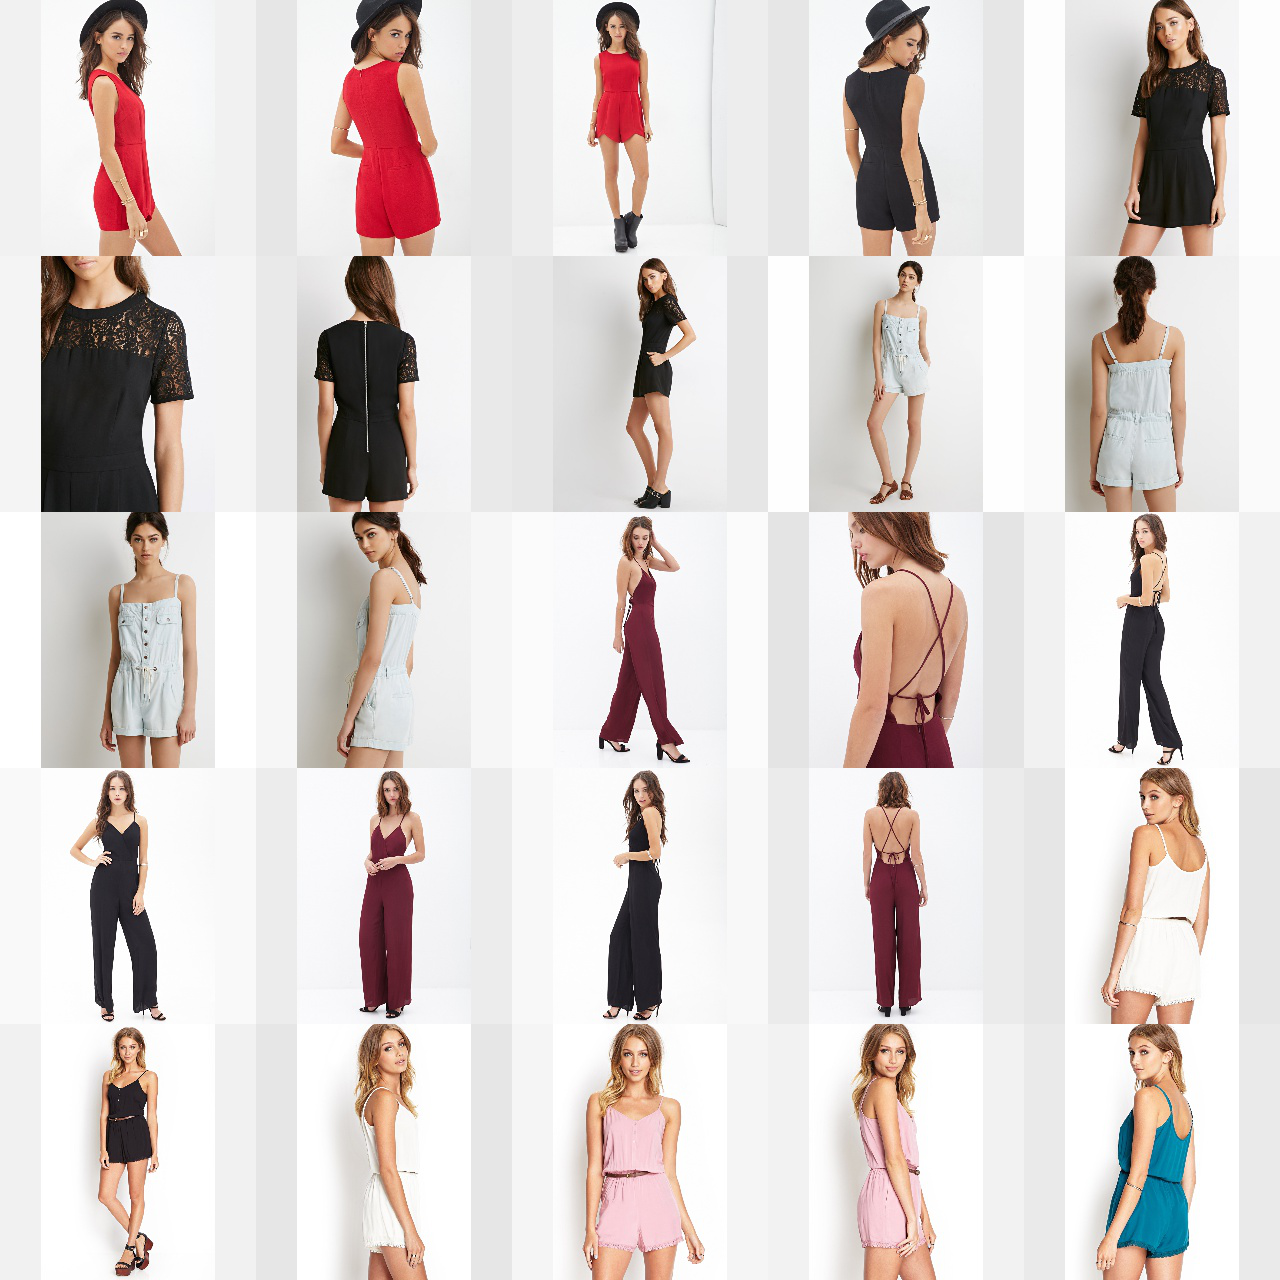

In [8]:
imgs=[Image.open(m) for m in img_fn[200:225]]
image_grid(imgs,5,5)


In [17]:
img_fn[:10]

['/home/guy/sd1tb/datasets/deep_fashion/DeepFashion/In-shop Clothes Retrieval Benchmark/Img/img/WOMEN/Rompers_Jumpsuits/id_00005449/02_4_full.jpg',
 '/home/guy/sd1tb/datasets/deep_fashion/DeepFashion/In-shop Clothes Retrieval Benchmark/Img/img/WOMEN/Rompers_Jumpsuits/id_00005449/02_1_front.jpg',
 '/home/guy/sd1tb/datasets/deep_fashion/DeepFashion/In-shop Clothes Retrieval Benchmark/Img/img/WOMEN/Rompers_Jumpsuits/id_00005449/02_7_additional.jpg',
 '/home/guy/sd1tb/datasets/deep_fashion/DeepFashion/In-shop Clothes Retrieval Benchmark/Img/img/WOMEN/Rompers_Jumpsuits/id_00005449/02_3_back.jpg',
 '/home/guy/sd1tb/datasets/deep_fashion/DeepFashion/In-shop Clothes Retrieval Benchmark/Img/img/WOMEN/Rompers_Jumpsuits/id_00005449/02_2_side.jpg',
 '/home/guy/sd1tb/datasets/deep_fashion/DeepFashion/In-shop Clothes Retrieval Benchmark/Img/img/WOMEN/Rompers_Jumpsuits/id_00003139/03_1_front.jpg',
 '/home/guy/sd1tb/datasets/deep_fashion/DeepFashion/In-shop Clothes Retrieval Benchmark/Img/img/WOMEN/Ro

OK, lets start with the `In-Shop-Clothes-Retreival-Benchmark` dataset and try to find a disentangled representation using VAEs

# Preparing the dataset
The goal is to prepare a dataset class and dataloader that we can use to train the VAE.
we can use the code from the `Text2Human` repo


In [2]:
import os.path

import numpy as np
import torch
import torch.utils.data as data
from torchvision.io import read_image

ImportError: cannot import name 'read_image'

In [3]:
import torchvision.io as tvio 

In [5]:
dir(tvio)

['__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'read_video',
 'read_video_timestamps',
 'video',
 'write_video']